In [447]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
 

df = pd.read_csv("data/train.csv")

In [448]:
def show_accuracy_confusion(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    print("Accuracy: " + str(accuracy_score(y_test, predictions)))
    ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()    

In [449]:
def fill_values(df):
    
    #Filling missing age values based on the median of Pclass/Sex groups
    df["Age"] = df.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.median()))

In [450]:
X = df.drop(["PassengerId", "Survived", "Embarked"], axis="columns")#X["Title"] = X["Name"].str.split(',').str.get(1).str.split('.').str.get(0)
y = df["Survived"]

In [451]:
fill_values(X)
X_enc = pd.get_dummies(X, columns = ["Pclass", "Sex"])

In [452]:
titles = X["Name"].str.split(',').str.get(1).str.split('.').str.get(0)

relevant_titles =  ['Mr', 'Mrs', 'Miss', 'Master']
pattern = '|'.join(relevant_titles)

titles = titles.loc[titles.str.contains(pattern)]

In [453]:
X_enc["Title"] = titles
X_enc = pd.get_dummies(X_enc, columns=["Title"])
X_enc = X_enc.drop(["Name", "Ticket", "Cabin"], axis="columns")

In [454]:
def isminor(row):
    if (row["Age"] < 18) or (row["Title_ Master"] == 1):
        return 1
    else:
        return 0

X_enc["isminor"] = X_enc.apply(lambda row: isminor(row), axis=1)

In [455]:
X_enc.head(20)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,isminor
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0
1,38.0,1,0,71.2833,1,0,0,1,0,0,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,1,0,0,0
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0
5,25.0,0,0,8.4583,0,0,1,0,1,0,0,1,0,0
6,54.0,0,0,51.8625,1,0,0,0,1,0,0,1,0,0
7,2.0,3,1,21.0750,0,0,1,0,1,1,0,0,0,1
8,27.0,0,2,11.1333,0,0,1,1,0,0,0,0,1,0
9,14.0,1,0,30.0708,0,1,0,1,0,0,0,0,1,1


In [466]:
default_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=10)

Accuracy: 0.8565022421524664


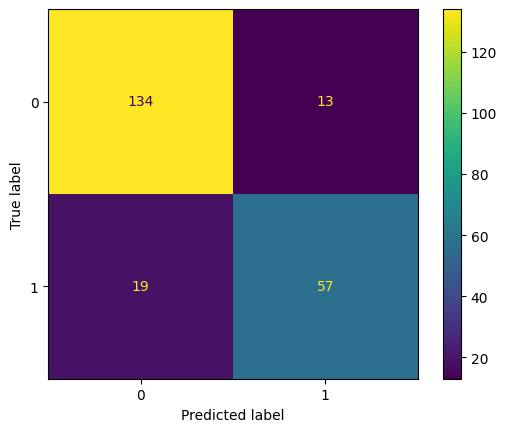

In [467]:
default_svc.fit(X_train, y_train)
predictions = default_svc.predict(X_test)

show_accuracy_confusion(default_svc, X_test, y_test)

In [468]:
forest = RandomForestClassifier(criterion="entropy", max_depth=5, n_estimators=300)
sgd = SGDClassifier(eta0=1, learning_rate="adaptive",n_jobs=-1, penalty="l2", loss="log_loss")
svc = SVC(kernel="poly", gamma=0.001, C = 2, coef0=1, degree=3)

for model in [forest, sgd, svc]:
    model.fit(X_train, y_train)

Accuracy: 0.852017937219731


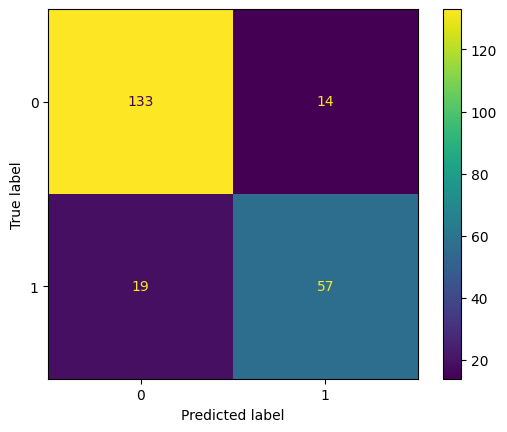

In [469]:
show_accuracy_confusion(forest, X_test, y_test)

Accuracy: 0.7937219730941704


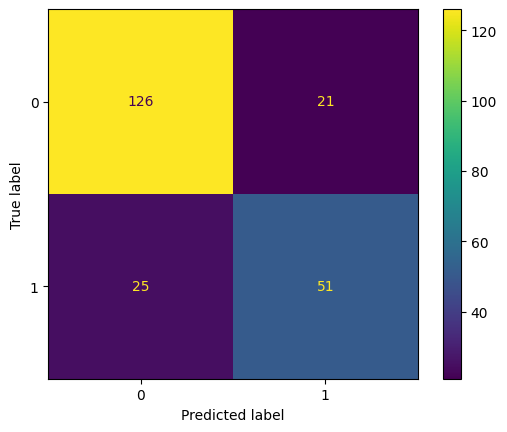

In [470]:
show_accuracy_confusion(sgd, X_test, y_test)

Accuracy: 0.8475336322869955


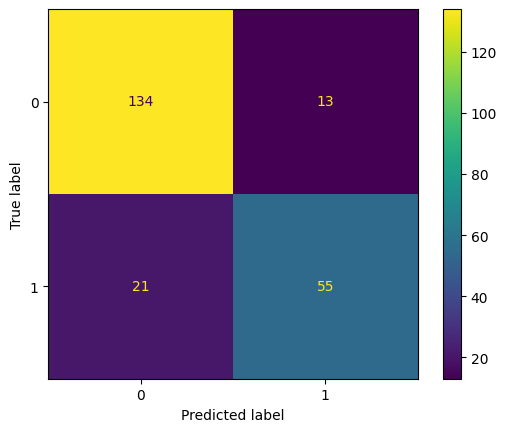

In [471]:
show_accuracy_confusion(svc, X_test, y_test)

In [ ]:
forest_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier())
])

forest_grid = {
    "forest__n_estimators": [200, 300, 350],
    "forest__max_depth": [3, 5, 6, None],
    "forest__criterion": ["gini", "entropy"],
}

forcv = GridSearchCV(estimator=forest_pipe, param_grid=forest_grid, cv = 10, scoring="accuracy")

forcv.fit(X_train, y_train)
forcv.best_params_

In [ ]:
show_accuracy_confusion(forcv, X_test, y_test)

In [ ]:
sgd_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDClassifier())
])

sgd_params = {
    "sgd__loss": ["hinge", "log_loss", "perceptron", "modified_huber"],
    "sgd__penalty": ["l2", "elasticnet", "l1", None],
    "sgd__learning_rate": ["adaptive", "optimal"],
    "sgd__n_jobs": [-1],
    "sgd__eta0" :[1, 2.15, 2.25, 2.5],
    "sgd__alpha": [0.0001, 0.01, 0.1],
    "sgd__l1_ratio": [0.15]
    
}

sgd_opt = GridSearchCV(estimator=sgd_pipe, cv=10, scoring="accuracy", param_grid=sgd_params)
sgd_opt.fit(X_train, y_train)
sgd_opt.best_params_

{'sgd__alpha': 0.01,
 'sgd__eta0': 2.25,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'modified_huber',
 'sgd__n_jobs': -1,
 'sgd__penalty': 'l1'}

In [ ]:
show_accuracy_confusion(sgd_opt, X_test, y_test)

In [472]:
pipe1 = Pipeline([
    ("scale", StandardScaler()),
    ("sgd1", SGDClassifier(alpha=0.01, eta0=2.5, l1_ratio=0.15, learning_rate='optimal', loss='log_loss',n_jobs=-1, penalty=None))
])

pipe2 = Pipeline([
    ("scale", StandardScaler()),
    ("sgd1", SGDClassifier(alpha=0.01, eta0=2.25, l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',n_jobs=-1, penalty='l1'))
])

In [473]:
for pipe in [pipe1, pipe2]:
    pipe.fit(X_train, y_train)

Accuracy: 0.8565022421524664


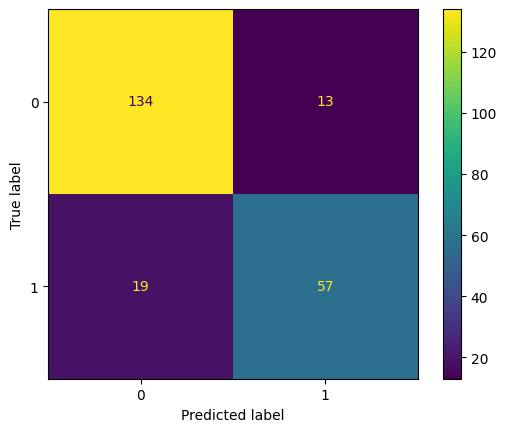

In [474]:
show_accuracy_confusion(pipe1, X_test, y_test)

Accuracy: 0.8161434977578476


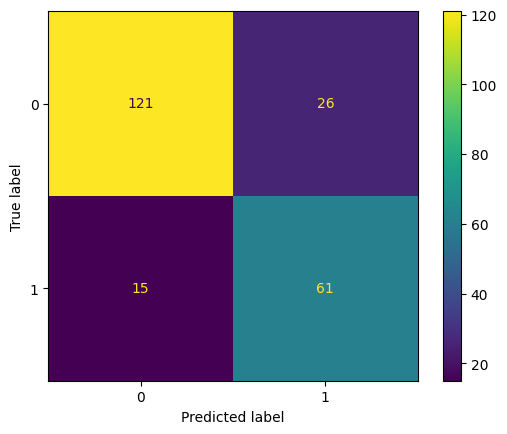

In [475]:
show_accuracy_confusion(pipe2, X_test, y_test)